In [4]:
import sys
import time
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path

input_size=40
train_size=128
validation_size=200
data_path='../../scratch/kh_1.nc'
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 547402471524305293
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 600047616
locality {
  bus_id: 1
}
incarnation: 16032878405865118913
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0"
]


In [5]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.25,0.25],variable='rho'):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
        self.first = 10
        
    def title(self):
        return 'integrated area: $[%f,%f]\\times [%f,%f]$'% (self.integrate_coordinate[0],
                                                            self.integrate_coordinate[1],
                                                            self.integrate_width[0],
                                                            self.integrate_width[1])
    def area(self, I):
        
        return 1*(I[1][0]-I[0][0])*(I[1][1]-I[0][1])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        g = sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
        
      
        return g
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[1]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
        
        
class SinglePointFunctional(object):
    def __init__(self, coordinate = [0.55,0.35], variable='rho'):
        self.coordinate = coordinate
        
        self.variable = variable
        self.first = 10
        
    def title(self):
        return 'specific point  $(%f,%f)$'% (self.coordinate[0], self.coordinate[1])

    def __call__(self, rho):
        N = rho.shape[0]
        
        x = int(N*self.coordinate[0])
        y = int(N*self.coordinate[1])
        
        return rho[x,y]
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.coordinate[0],self.coordinate[1]),
                                     0.05,
                                     0.05,
                                     linewidth=1,edgecolor='r',facecolor='r')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
    
    

In [6]:
def get_samples(data_path, functional):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
                
               
    print()
    return array(samples,dtype=float64)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

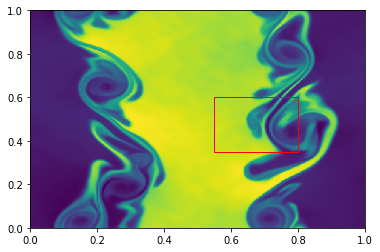

In [7]:
draw_functional(data_path, AreaFunctional())

In [8]:
def get_network_from_functional(data_path, functional, parameters, epochs=500000):
    start_reading_samples = time.time()
    samples = get_samples(data_path, functional)
    end_reading_samples = time.time()
    print("Reading all samples took {} seconds".format(end_reading_samples-start_reading_samples))
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size, epochs=epochs,
                      title=functional.title())
def get_network_from_functional_qmc(data_path, functional,epochs=500000):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)
    
    return get_network_from_functional(data_path, functional, parameters, epochs)
def get_network(parameters, data, *, train_size, validation_size, epochs=500000, title=''):
    import numpy as np
    
    print(type(data))
    print(data.shape)
    if np.isnan(data).any():
        print("We have a nan!")
    if np.isinf(data).any():
        print("we have an inf!")
        
    input_size = parameters.shape[1]
    model = Sequential([
        Dense(200, input_shape=(input_size,)),
        Activation('relu'),
        Dense(220),
        Activation('relu'),
        Dense(200),
        Activation('relu'),
        Dense(220),
        Activation('relu'),
        Dense(200),
        Activation('relu'),
        Dense(200),
        Activation('relu'),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
  
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size]
   
    epochs_r=range(1, epochs)
   
    start_training_time = time.time()
    hist = model.fit(x_train, y_train,batch_size=train_size, epochs=epochs,shuffle=True,
                     validation_data=(x_val, y_val),verbose=0)
    end_training_time = time.time()
    print("Training took {} seconds".format(end_training_time-start_training_time))
    plt.loglog(hist.history['loss'])
    plt.title("Training loss\n%s\n(epochs=%d)" % (title, epochs))
    showAndSave("training_loss")
    
    plt.loglog(hist.history['val_loss'])
    plt.title("Validation loss\n%s\n(epochs=%d)" % (title, epochs))
    showAndSave("training_loss")
    x_test = parameters
    y_test = data
    y_predict = model.predict(x_test)
    print(y_test.shape)
    print(y_predict.shape)
    plt.scatter(y_test, y_predict[:,0])
    plt.title("Scatter plot, \n%s,\n epochs=%d" % (title, epochs))
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    showAndSave("scatter_ml")
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data, parameters

In [9]:
def get_network_interpolate_qmc(data_path, functional, epochs=500000):
    draw_functional(data_path, functional)
    network, data, parameters = get_network_from_functional_qmc(data_path, functional, epochs)
    
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    y_train = data[:train_size]
    coeffs = reg.fit(parameters[:train_size,:], y_train)

    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Linear least squares\n%s' % functional.title())
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    plt.show()
    
    def myvar(x):
        mean = sum(x)/x.shape[0]
        var = sum((mean-x)**2)/x.shape[0]
        return var
    
    def mymean (x): 
        return sum(x)/x.shape[0]
    
    
   
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = network.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data- predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml/2.))
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = mymean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = mymean(network.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = mymean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    print("mean_lsq = %f" % mean(evaluated_lsq))
    
    
    
    
    predicted_all = network.predict(parameters)
    predicted_all = predicted_all.reshape(parameters.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = myvar(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = myvar(network.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = myvar(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    print("var_lsq = %f" % var(evaluated_lsq))
    
    title = functional.title()
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.title("Comparison QMC and Machine learning\n%s\nepochs=%d"% (title, epochs))
    plt.hist(network.predict(parameters),bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml')
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples\n%s" %(8192, train_size, title))
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc')
    
    plt.title("Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq')
    
    return network, data, parameters

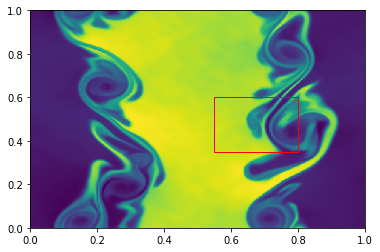

8191
Reading all samples took 303.32797956466675 seconds
<class 'numpy.ndarray'>
(8192,)
Train on 128 samples, validate on 200 samples
Epoch 1/5000
128/128 [==============================] - 6s 45ms/step - loss: 2.5754 - val_loss: 2.1445
Epoch 2/5000
128/128 [==============================] - 0s 33us/step - loss: 2.1454 - val_loss: 1.7562
Epoch 3/5000
128/128 [==============================] - 0s 32us/step - loss: 1.7570 - val_loss: 1.3861
Epoch 4/5000
128/128 [==============================] - 0s 31us/step - loss: 1.3869 - val_loss: 1.0307
Epoch 5/5000
128/128 [==============================] - 0s 30us/step - loss: 1.0319 - val_loss: 0.7037
Epoch 6/5000
128/128 [==============================] - 0s 30us/step - loss: 0.7039 - val_loss: 0.4315
Epoch 7/5000
128/128 [==============================] - 0s 30us/step - loss: 0.4302 - val_loss: 0.2373
Epoch 8/5000
128/128 [==============================] - 0s 31us/step - loss: 0.2347 - val_loss: 0.1257
Epoch 9/5000
128/128 [===================

Epoch 79/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0403 - val_loss: 0.0503
Epoch 80/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0402 - val_loss: 0.0503
Epoch 81/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0401 - val_loss: 0.0503
Epoch 82/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0401 - val_loss: 0.0502
Epoch 83/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0400 - val_loss: 0.0502
Epoch 84/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0399 - val_loss: 0.0502
Epoch 85/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0398 - val_loss: 0.0501
Epoch 86/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0398 - val_loss: 0.0501
Epoch 87/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0397 - val_loss: 0.0501
Epoch 88/5000
128/128 [==============================] - 0s 30us

Epoch 158/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0353 - val_loss: 0.0480
Epoch 159/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0353 - val_loss: 0.0480
Epoch 160/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0352 - val_loss: 0.0479
Epoch 161/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0352 - val_loss: 0.0479
Epoch 162/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0351 - val_loss: 0.0479
Epoch 163/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0351 - val_loss: 0.0479
Epoch 164/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0350 - val_loss: 0.0478
Epoch 165/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0350 - val_loss: 0.0478
Epoch 166/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0349 - val_loss: 0.0478
Epoch 167/5000
128/128 [==============================]

128/128 [==============================] - 0s 31us/step - loss: 0.0319 - val_loss: 0.0463
Epoch 237/5000
128/128 [==============================] - 0s 41us/step - loss: 0.0318 - val_loss: 0.0463
Epoch 238/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0318 - val_loss: 0.0463
Epoch 239/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0317 - val_loss: 0.0463
Epoch 240/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0317 - val_loss: 0.0463
Epoch 241/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0317 - val_loss: 0.0462
Epoch 242/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0316 - val_loss: 0.0462
Epoch 243/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0316 - val_loss: 0.0462
Epoch 244/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0315 - val_loss: 0.0462
Epoch 245/5000
128/128 [==============================] - 0s 32us/step

Epoch 315/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0291 - val_loss: 0.0451
Epoch 316/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0291 - val_loss: 0.0451
Epoch 317/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0291 - val_loss: 0.0450
Epoch 318/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0290 - val_loss: 0.0450
Epoch 319/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0290 - val_loss: 0.0450
Epoch 320/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0290 - val_loss: 0.0450
Epoch 321/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0289 - val_loss: 0.0450
Epoch 322/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0289 - val_loss: 0.0450
Epoch 323/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0289 - val_loss: 0.0450
Epoch 324/5000
128/128 [==============================]

128/128 [==============================] - 0s 31us/step - loss: 0.0269 - val_loss: 0.0441
Epoch 394/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0268 - val_loss: 0.0441
Epoch 395/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0268 - val_loss: 0.0441
Epoch 396/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0268 - val_loss: 0.0440
Epoch 397/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0268 - val_loss: 0.0440
Epoch 398/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0267 - val_loss: 0.0440
Epoch 399/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0267 - val_loss: 0.0440
Epoch 400/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0267 - val_loss: 0.0440
Epoch 401/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0267 - val_loss: 0.0440
Epoch 402/5000
128/128 [==============================] - 0s 31us/step

Epoch 472/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0249 - val_loss: 0.0433
Epoch 473/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0249 - val_loss: 0.0433
Epoch 474/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0249 - val_loss: 0.0432
Epoch 475/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0248 - val_loss: 0.0432
Epoch 476/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0248 - val_loss: 0.0432
Epoch 477/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0248 - val_loss: 0.0432
Epoch 478/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0248 - val_loss: 0.0432
Epoch 479/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0247 - val_loss: 0.0432
Epoch 480/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0247 - val_loss: 0.0432
Epoch 481/5000
128/128 [==============================]

128/128 [==============================] - 0s 33us/step - loss: 0.0232 - val_loss: 0.0426
Epoch 551/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0232 - val_loss: 0.0426
Epoch 552/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0232 - val_loss: 0.0426
Epoch 553/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0232 - val_loss: 0.0426
Epoch 554/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0231 - val_loss: 0.0426
Epoch 555/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0231 - val_loss: 0.0426
Epoch 556/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0231 - val_loss: 0.0426
Epoch 557/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0231 - val_loss: 0.0426
Epoch 558/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0231 - val_loss: 0.0426
Epoch 559/5000
128/128 [==============================] - 0s 31us/step

Epoch 629/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0217 - val_loss: 0.0420
Epoch 630/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0217 - val_loss: 0.0420
Epoch 631/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0217 - val_loss: 0.0420
Epoch 632/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0217 - val_loss: 0.0420
Epoch 633/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0217 - val_loss: 0.0420
Epoch 634/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0216 - val_loss: 0.0420
Epoch 635/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0216 - val_loss: 0.0420
Epoch 636/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0216 - val_loss: 0.0420
Epoch 637/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0216 - val_loss: 0.0420
Epoch 638/5000
128/128 [==============================]

128/128 [==============================] - 0s 31us/step - loss: 0.0204 - val_loss: 0.0416
Epoch 708/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0204 - val_loss: 0.0416
Epoch 709/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0204 - val_loss: 0.0415
Epoch 710/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0203 - val_loss: 0.0415
Epoch 711/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0203 - val_loss: 0.0415
Epoch 712/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0203 - val_loss: 0.0415
Epoch 713/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0203 - val_loss: 0.0415
Epoch 714/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0203 - val_loss: 0.0415
Epoch 715/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0203 - val_loss: 0.0415
Epoch 716/5000
128/128 [==============================] - 0s 30us/step

Epoch 786/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0192 - val_loss: 0.0411
Epoch 787/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 788/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 789/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 790/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 791/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 792/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 793/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 794/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0190 - val_loss: 0.0411
Epoch 795/5000
128/128 [==============================]

128/128 [==============================] - 0s 32us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 865/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 866/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 867/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 868/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 869/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 870/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 871/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0180 - val_loss: 0.0408
Epoch 872/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0179 - val_loss: 0.0408
Epoch 873/5000
128/128 [==============================] - 0s 31us/step

Epoch 943/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 944/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 945/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 946/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 947/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 948/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 949/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 950/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0169 - val_loss: 0.0405
Epoch 951/5000
128/128 [==============================] - 0s 37us/step - loss: 0.0169 - val_loss: 0.0405
Epoch 952/5000
128/128 [==============================]

Epoch 1021/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0161 - val_loss: 0.0403
Epoch 1022/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0161 - val_loss: 0.0403
Epoch 1023/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0161 - val_loss: 0.0403
Epoch 1024/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0161 - val_loss: 0.0403
Epoch 1025/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0160 - val_loss: 0.0403
Epoch 1026/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0160 - val_loss: 0.0403
Epoch 1027/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0160 - val_loss: 0.0403
Epoch 1028/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0160 - val_loss: 0.0403
Epoch 1029/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0160 - val_loss: 0.0403
Epoch 1030/5000
128/128 [=====================

Epoch 1099/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0152 - val_loss: 0.0401
Epoch 1100/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0152 - val_loss: 0.0401
Epoch 1101/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0152 - val_loss: 0.0401
Epoch 1102/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0152 - val_loss: 0.0401
Epoch 1103/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0152 - val_loss: 0.0401
Epoch 1104/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0152 - val_loss: 0.0401
Epoch 1105/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0151 - val_loss: 0.0401
Epoch 1106/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0151 - val_loss: 0.0401
Epoch 1107/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0151 - val_loss: 0.0401
Epoch 1108/5000
128/128 [=====================

Epoch 1177/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0144 - val_loss: 0.0400
Epoch 1178/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0144 - val_loss: 0.0400
Epoch 1179/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 1180/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 1181/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 1182/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 1183/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 1184/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 1185/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 1186/5000
128/128 [=====================

Epoch 1255/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1256/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1257/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1258/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1259/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1260/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1261/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1262/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0135 - val_loss: 0.0399
Epoch 1263/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0134 - val_loss: 0.0399
Epoch 1264/5000
128/128 [=====================

Epoch 1333/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1334/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1335/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1336/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1337/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1338/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1339/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1340/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1341/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0127 - val_loss: 0.0398
Epoch 1342/5000
128/128 [=====================

Epoch 1411/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0120 - val_loss: 0.0398
Epoch 1412/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0120 - val_loss: 0.0398
Epoch 1413/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0120 - val_loss: 0.0398
Epoch 1414/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0120 - val_loss: 0.0398
Epoch 1415/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0120 - val_loss: 0.0398
Epoch 1416/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0119 - val_loss: 0.0398
Epoch 1417/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0119 - val_loss: 0.0398
Epoch 1418/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0119 - val_loss: 0.0398
Epoch 1419/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0119 - val_loss: 0.0398
Epoch 1420/5000
128/128 [=====================

Epoch 1489/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0113 - val_loss: 0.0397
Epoch 1490/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0113 - val_loss: 0.0397
Epoch 1491/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0112 - val_loss: 0.0397
Epoch 1492/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0112 - val_loss: 0.0397
Epoch 1493/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0112 - val_loss: 0.0397
Epoch 1494/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0112 - val_loss: 0.0397
Epoch 1495/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0112 - val_loss: 0.0397
Epoch 1496/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0112 - val_loss: 0.0397
Epoch 1497/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0112 - val_loss: 0.0397
Epoch 1498/5000
128/128 [=====================

Epoch 1567/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0106 - val_loss: 0.0396
Epoch 1568/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1569/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1570/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1571/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1572/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1573/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1574/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1575/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0105 - val_loss: 0.0396
Epoch 1576/5000
128/128 [=====================

Epoch 1645/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0099 - val_loss: 0.0396
Epoch 1646/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0099 - val_loss: 0.0396
Epoch 1647/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0099 - val_loss: 0.0396
Epoch 1648/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0099 - val_loss: 0.0396
Epoch 1649/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0099 - val_loss: 0.0396
Epoch 1650/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0098 - val_loss: 0.0396
Epoch 1651/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0098 - val_loss: 0.0396
Epoch 1652/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0098 - val_loss: 0.0396
Epoch 1653/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0098 - val_loss: 0.0396
Epoch 1654/5000
128/128 [=====================

Epoch 1723/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0093 - val_loss: 0.0395
Epoch 1724/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1725/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1726/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1727/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1728/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1729/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1730/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1731/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0092 - val_loss: 0.0395
Epoch 1732/5000
128/128 [=====================

Epoch 1801/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1802/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1803/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1804/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1805/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1806/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1807/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1808/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1809/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0086 - val_loss: 0.0395
Epoch 1810/5000
128/128 [=====================

Epoch 1879/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1880/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1881/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1882/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1883/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1884/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1885/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1886/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1887/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0080 - val_loss: 0.0395
Epoch 1888/5000
128/128 [=====================

Epoch 1957/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0075 - val_loss: 0.0396
Epoch 1958/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0075 - val_loss: 0.0396
Epoch 1959/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0075 - val_loss: 0.0396
Epoch 1960/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0075 - val_loss: 0.0396
Epoch 1961/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0075 - val_loss: 0.0396
Epoch 1962/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0074 - val_loss: 0.0396
Epoch 1963/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0074 - val_loss: 0.0396
Epoch 1964/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0074 - val_loss: 0.0396
Epoch 1965/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0074 - val_loss: 0.0396
Epoch 1966/5000
128/128 [=====================

Epoch 2035/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0070 - val_loss: 0.0396
Epoch 2036/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2037/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2038/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2039/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2040/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2041/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2042/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2043/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0069 - val_loss: 0.0396
Epoch 2044/5000
128/128 [=====================

Epoch 2113/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0065 - val_loss: 0.0397
Epoch 2114/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2115/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2116/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2117/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2118/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2119/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2120/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2121/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0064 - val_loss: 0.0397
Epoch 2122/5000
128/128 [=====================

Epoch 2191/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0060 - val_loss: 0.0397
Epoch 2192/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0060 - val_loss: 0.0397
Epoch 2193/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0060 - val_loss: 0.0397
Epoch 2194/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0060 - val_loss: 0.0397
Epoch 2195/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0060 - val_loss: 0.0397
Epoch 2196/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0060 - val_loss: 0.0397
Epoch 2197/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0060 - val_loss: 0.0397
Epoch 2198/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0059 - val_loss: 0.0397
Epoch 2199/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0059 - val_loss: 0.0397
Epoch 2200/5000
128/128 [=====================

Epoch 2269/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2270/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2271/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2272/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2273/5000
128/128 [==============================] - 0s 38us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2274/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2275/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2276/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2277/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0055 - val_loss: 0.0398
Epoch 2278/5000
128/128 [=====================

Epoch 2347/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2348/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2349/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2350/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2351/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2352/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2353/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2354/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2355/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0051 - val_loss: 0.0398
Epoch 2356/5000
128/128 [=====================

Epoch 2425/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2426/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2427/5000
128/128 [==============================] - 0s 39us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2428/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2429/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2430/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2431/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2432/5000
128/128 [==============================] - 0s 37us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2433/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0047 - val_loss: 0.0398
Epoch 2434/5000
128/128 [=====================

Epoch 2503/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0044 - val_loss: 0.0399
Epoch 2504/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0044 - val_loss: 0.0399
Epoch 2505/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0043 - val_loss: 0.0399
Epoch 2506/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0043 - val_loss: 0.0399
Epoch 2507/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0043 - val_loss: 0.0399
Epoch 2508/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0043 - val_loss: 0.0399
Epoch 2509/5000
128/128 [==============================] - 0s 37us/step - loss: 0.0043 - val_loss: 0.0399
Epoch 2510/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0043 - val_loss: 0.0399
Epoch 2511/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0043 - val_loss: 0.0399
Epoch 2512/5000
128/128 [=====================

Epoch 2581/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2582/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2583/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2584/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2585/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2586/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2587/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2588/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2589/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0040 - val_loss: 0.0399
Epoch 2590/5000
128/128 [=====================

Epoch 2659/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2660/5000
128/128 [==============================] - 0s 37us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2661/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2662/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2663/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2664/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2665/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2666/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0037 - val_loss: 0.0400
Epoch 2667/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0036 - val_loss: 0.0400
Epoch 2668/5000
128/128 [=====================

Epoch 2737/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0400
Epoch 2738/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0400
Epoch 2739/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0400
Epoch 2740/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0400
Epoch 2741/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0400
Epoch 2742/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0400
Epoch 2743/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0400
Epoch 2744/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0033 - val_loss: 0.0400
Epoch 2745/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0400
Epoch 2746/5000
128/128 [=====================

Epoch 2815/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2816/5000
128/128 [==============================] - 0s 28us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2817/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2818/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2819/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2820/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2821/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2822/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2823/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0031 - val_loss: 0.0400
Epoch 2824/5000
128/128 [=====================

Epoch 2893/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2894/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2895/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2896/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2897/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2898/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2899/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2900/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2901/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0028 - val_loss: 0.0401
Epoch 2902/5000
128/128 [=====================

Epoch 2971/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2972/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2973/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2974/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2975/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2976/5000
128/128 [==============================] - 0s 38us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2977/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2978/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2979/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0026 - val_loss: 0.0401
Epoch 2980/5000
128/128 [=====================

Epoch 3049/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3050/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3051/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3052/5000
128/128 [==============================] - 0s 36us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3053/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3054/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3055/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3056/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3057/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0023 - val_loss: 0.0402
Epoch 3058/5000
128/128 [=====================

Epoch 3127/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3128/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3129/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3130/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3131/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3132/5000
128/128 [==============================] - 0s 35us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3133/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3134/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0021 - val_loss: 0.0402
Epoch 3135/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0021 - val_loss: 0.0403
Epoch 3136/5000
128/128 [=====================

Epoch 3205/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3206/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3207/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3208/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3209/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3210/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3211/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3212/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3213/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 0.0403
Epoch 3214/5000
128/128 [=====================

Epoch 3283/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3284/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3285/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3286/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3287/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3288/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3289/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3290/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3291/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0018 - val_loss: 0.0403
Epoch 3292/5000
128/128 [=====================

Epoch 3361/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3362/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3363/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3364/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3365/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3366/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3367/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3368/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3369/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0016 - val_loss: 0.0404
Epoch 3370/5000
128/128 [=====================

Epoch 3439/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3440/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3441/5000
128/128 [==============================] - 0s 37us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3442/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3443/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3444/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3445/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3446/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0015 - val_loss: 0.0404
Epoch 3447/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0014 - val_loss: 0.0404
Epoch 3448/5000
128/128 [=====================

Epoch 3517/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3518/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3519/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3520/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3521/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3522/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3523/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3524/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3525/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0013 - val_loss: 0.0405
Epoch 3526/5000
128/128 [=====================

Epoch 3595/5000
128/128 [==============================] - 0s 33us/step - loss: 0.0012 - val_loss: 0.0405
Epoch 3596/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0012 - val_loss: 0.0405
Epoch 3597/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0012 - val_loss: 0.0405
Epoch 3598/5000
128/128 [==============================] - 0s 32us/step - loss: 0.0012 - val_loss: 0.0405
Epoch 3599/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0012 - val_loss: 0.0405
Epoch 3600/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0012 - val_loss: 0.0405
Epoch 3601/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0012 - val_loss: 0.0406
Epoch 3602/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0012 - val_loss: 0.0405
Epoch 3603/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0012 - val_loss: 0.0406
Epoch 3604/5000
128/128 [=====================

Epoch 3673/5000
128/128 [==============================] - 0s 34us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3674/5000
128/128 [==============================] - 0s 46us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3675/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3676/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3677/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3678/5000
128/128 [==============================] - 0s 30us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3679/5000
128/128 [==============================] - 0s 31us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3680/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3681/5000
128/128 [==============================] - 0s 29us/step - loss: 0.0011 - val_loss: 0.0406
Epoch 3682/5000
128/128 [=====================

128/128 [==============================] - 0s 36us/step - loss: 9.9228e-04 - val_loss: 0.0406
Epoch 3751/5000
128/128 [==============================] - 0s 34us/step - loss: 9.9105e-04 - val_loss: 0.0406
Epoch 3752/5000
128/128 [==============================] - 0s 36us/step - loss: 9.8984e-04 - val_loss: 0.0406
Epoch 3753/5000
128/128 [==============================] - 0s 31us/step - loss: 9.8855e-04 - val_loss: 0.0406
Epoch 3754/5000
128/128 [==============================] - 0s 31us/step - loss: 9.8737e-04 - val_loss: 0.0406
Epoch 3755/5000
128/128 [==============================] - 0s 30us/step - loss: 9.8611e-04 - val_loss: 0.0406
Epoch 3756/5000
128/128 [==============================] - 0s 33us/step - loss: 9.8491e-04 - val_loss: 0.0406
Epoch 3757/5000
128/128 [==============================] - 0s 30us/step - loss: 9.8365e-04 - val_loss: 0.0406
Epoch 3758/5000
128/128 [==============================] - 0s 29us/step - loss: 9.8243e-04 - val_loss: 0.0406
Epoch 3759/5000
128/128 [=

Epoch 3825/5000
128/128 [==============================] - 0s 32us/step - loss: 9.0327e-04 - val_loss: 0.0407
Epoch 3826/5000
128/128 [==============================] - 0s 30us/step - loss: 9.0214e-04 - val_loss: 0.0407
Epoch 3827/5000
128/128 [==============================] - 0s 32us/step - loss: 9.0103e-04 - val_loss: 0.0407
Epoch 3828/5000
128/128 [==============================] - 0s 30us/step - loss: 8.9986e-04 - val_loss: 0.0407
Epoch 3829/5000
128/128 [==============================] - 0s 30us/step - loss: 8.9875e-04 - val_loss: 0.0407
Epoch 3830/5000
128/128 [==============================] - 0s 31us/step - loss: 8.9757e-04 - val_loss: 0.0407
Epoch 3831/5000
128/128 [==============================] - 0s 30us/step - loss: 8.9649e-04 - val_loss: 0.0407
Epoch 3832/5000
128/128 [==============================] - 0s 30us/step - loss: 8.9534e-04 - val_loss: 0.0407
Epoch 3833/5000
128/128 [==============================] - 0s 30us/step - loss: 8.9428e-04 - val_loss: 0.0407
Epoch 3834

Epoch 3900/5000
128/128 [==============================] - 0s 32us/step - loss: 8.2143e-04 - val_loss: 0.0407
Epoch 3901/5000
128/128 [==============================] - 0s 31us/step - loss: 8.2040e-04 - val_loss: 0.0407
Epoch 3902/5000
128/128 [==============================] - 0s 31us/step - loss: 8.1935e-04 - val_loss: 0.0407
Epoch 3903/5000
128/128 [==============================] - 0s 31us/step - loss: 8.1827e-04 - val_loss: 0.0407
Epoch 3904/5000
128/128 [==============================] - 0s 32us/step - loss: 8.1723e-04 - val_loss: 0.0407
Epoch 3905/5000
128/128 [==============================] - 0s 31us/step - loss: 8.1620e-04 - val_loss: 0.0407
Epoch 3906/5000
128/128 [==============================] - 0s 32us/step - loss: 8.1521e-04 - val_loss: 0.0407
Epoch 3907/5000
128/128 [==============================] - 0s 31us/step - loss: 8.1413e-04 - val_loss: 0.0407
Epoch 3908/5000
128/128 [==============================] - 0s 32us/step - loss: 8.1313e-04 - val_loss: 0.0407
Epoch 3909

Epoch 3975/5000
128/128 [==============================] - 0s 31us/step - loss: 7.4634e-04 - val_loss: 0.0408
Epoch 3976/5000
128/128 [==============================] - 0s 29us/step - loss: 7.4540e-04 - val_loss: 0.0408
Epoch 3977/5000
128/128 [==============================] - 0s 30us/step - loss: 7.4440e-04 - val_loss: 0.0408
Epoch 3978/5000
128/128 [==============================] - 0s 31us/step - loss: 7.4342e-04 - val_loss: 0.0408
Epoch 3979/5000
128/128 [==============================] - 0s 32us/step - loss: 7.4246e-04 - val_loss: 0.0408
Epoch 3980/5000
128/128 [==============================] - 0s 32us/step - loss: 7.4151e-04 - val_loss: 0.0408
Epoch 3981/5000
128/128 [==============================] - 0s 30us/step - loss: 7.4055e-04 - val_loss: 0.0408
Epoch 3982/5000
128/128 [==============================] - 0s 32us/step - loss: 7.3964e-04 - val_loss: 0.0408
Epoch 3983/5000
128/128 [==============================] - 0s 32us/step - loss: 7.3867e-04 - val_loss: 0.0408
Epoch 3984

Epoch 4050/5000
128/128 [==============================] - 0s 30us/step - loss: 6.7783e-04 - val_loss: 0.0408
Epoch 4051/5000
128/128 [==============================] - 0s 29us/step - loss: 6.7698e-04 - val_loss: 0.0408
Epoch 4052/5000
128/128 [==============================] - 0s 32us/step - loss: 6.7610e-04 - val_loss: 0.0408
Epoch 4053/5000
128/128 [==============================] - 0s 33us/step - loss: 6.7525e-04 - val_loss: 0.0408
Epoch 4054/5000
128/128 [==============================] - 0s 32us/step - loss: 6.7437e-04 - val_loss: 0.0408
Epoch 4055/5000
128/128 [==============================] - 0s 30us/step - loss: 6.7354e-04 - val_loss: 0.0408
Epoch 4056/5000
128/128 [==============================] - 0s 30us/step - loss: 6.7266e-04 - val_loss: 0.0408
Epoch 4057/5000
128/128 [==============================] - 0s 33us/step - loss: 6.7182e-04 - val_loss: 0.0408
Epoch 4058/5000
128/128 [==============================] - 0s 36us/step - loss: 6.7094e-04 - val_loss: 0.0408
Epoch 4059

Epoch 4125/5000
128/128 [==============================] - 0s 37us/step - loss: 6.1577e-04 - val_loss: 0.0408
Epoch 4126/5000
128/128 [==============================] - 0s 30us/step - loss: 6.1499e-04 - val_loss: 0.0408
Epoch 4127/5000
128/128 [==============================] - 0s 31us/step - loss: 6.1422e-04 - val_loss: 0.0408
Epoch 4128/5000
128/128 [==============================] - 0s 30us/step - loss: 6.1339e-04 - val_loss: 0.0408
Epoch 4129/5000
128/128 [==============================] - 0s 31us/step - loss: 6.1263e-04 - val_loss: 0.0408
Epoch 4130/5000
128/128 [==============================] - 0s 39us/step - loss: 6.1183e-04 - val_loss: 0.0408
Epoch 4131/5000
128/128 [==============================] - 0s 30us/step - loss: 6.1107e-04 - val_loss: 0.0409
Epoch 4132/5000
128/128 [==============================] - 0s 31us/step - loss: 6.1026e-04 - val_loss: 0.0408
Epoch 4133/5000
128/128 [==============================] - 0s 31us/step - loss: 6.0948e-04 - val_loss: 0.0409
Epoch 4134

Epoch 4200/5000
128/128 [==============================] - 0s 30us/step - loss: 5.5894e-04 - val_loss: 0.0409
Epoch 4201/5000
128/128 [==============================] - 0s 36us/step - loss: 5.5822e-04 - val_loss: 0.0409
Epoch 4202/5000
128/128 [==============================] - 0s 31us/step - loss: 5.5747e-04 - val_loss: 0.0409
Epoch 4203/5000
128/128 [==============================] - 0s 36us/step - loss: 5.5679e-04 - val_loss: 0.0409
Epoch 4204/5000
128/128 [==============================] - 0s 34us/step - loss: 5.5607e-04 - val_loss: 0.0409
Epoch 4205/5000
128/128 [==============================] - 0s 31us/step - loss: 5.5534e-04 - val_loss: 0.0409
Epoch 4206/5000
128/128 [==============================] - 0s 31us/step - loss: 5.5463e-04 - val_loss: 0.0409
Epoch 4207/5000
128/128 [==============================] - 0s 30us/step - loss: 5.5393e-04 - val_loss: 0.0409
Epoch 4208/5000
128/128 [==============================] - 0s 30us/step - loss: 5.5319e-04 - val_loss: 0.0409
Epoch 4209

Epoch 4275/5000
128/128 [==============================] - 0s 31us/step - loss: 5.0723e-04 - val_loss: 0.0409
Epoch 4276/5000
128/128 [==============================] - 0s 30us/step - loss: 5.0657e-04 - val_loss: 0.0409
Epoch 4277/5000
128/128 [==============================] - 0s 33us/step - loss: 5.0591e-04 - val_loss: 0.0409
Epoch 4278/5000
128/128 [==============================] - 0s 30us/step - loss: 5.0525e-04 - val_loss: 0.0409
Epoch 4279/5000
128/128 [==============================] - 0s 30us/step - loss: 5.0462e-04 - val_loss: 0.0409
Epoch 4280/5000
128/128 [==============================] - 0s 32us/step - loss: 5.0394e-04 - val_loss: 0.0409
Epoch 4281/5000
128/128 [==============================] - 0s 30us/step - loss: 5.0329e-04 - val_loss: 0.0409
Epoch 4282/5000
128/128 [==============================] - 0s 32us/step - loss: 5.0262e-04 - val_loss: 0.0409
Epoch 4283/5000
128/128 [==============================] - 0s 34us/step - loss: 5.0197e-04 - val_loss: 0.0409
Epoch 4284

Epoch 4350/5000
128/128 [==============================] - 0s 37us/step - loss: 4.6043e-04 - val_loss: 0.0409
Epoch 4351/5000
128/128 [==============================] - 0s 31us/step - loss: 4.5985e-04 - val_loss: 0.0409
Epoch 4352/5000
128/128 [==============================] - 0s 31us/step - loss: 4.5925e-04 - val_loss: 0.0409
Epoch 4353/5000
128/128 [==============================] - 0s 30us/step - loss: 4.5866e-04 - val_loss: 0.0409
Epoch 4354/5000
128/128 [==============================] - 0s 30us/step - loss: 4.5806e-04 - val_loss: 0.0409
Epoch 4355/5000
128/128 [==============================] - 0s 31us/step - loss: 4.5746e-04 - val_loss: 0.0409
Epoch 4356/5000
128/128 [==============================] - 0s 30us/step - loss: 4.5686e-04 - val_loss: 0.0409
Epoch 4357/5000
128/128 [==============================] - 0s 33us/step - loss: 4.5627e-04 - val_loss: 0.0409
Epoch 4358/5000
128/128 [==============================] - 0s 31us/step - loss: 4.5568e-04 - val_loss: 0.0409
Epoch 4359

Epoch 4425/5000
128/128 [==============================] - 0s 32us/step - loss: 4.1793e-04 - val_loss: 0.0410
Epoch 4426/5000
128/128 [==============================] - 0s 33us/step - loss: 4.1736e-04 - val_loss: 0.0410
Epoch 4427/5000
128/128 [==============================] - 0s 30us/step - loss: 4.1682e-04 - val_loss: 0.0410
Epoch 4428/5000
128/128 [==============================] - 0s 30us/step - loss: 4.1627e-04 - val_loss: 0.0410
Epoch 4429/5000
128/128 [==============================] - 0s 31us/step - loss: 4.1573e-04 - val_loss: 0.0410
Epoch 4430/5000
128/128 [==============================] - 0s 34us/step - loss: 4.1518e-04 - val_loss: 0.0410
Epoch 4431/5000
128/128 [==============================] - 0s 32us/step - loss: 4.1465e-04 - val_loss: 0.0410
Epoch 4432/5000
128/128 [==============================] - 0s 31us/step - loss: 4.1411e-04 - val_loss: 0.0410
Epoch 4433/5000
128/128 [==============================] - 0s 31us/step - loss: 4.1358e-04 - val_loss: 0.0410
Epoch 4434

Epoch 4500/5000
128/128 [==============================] - 0s 30us/step - loss: 3.7914e-04 - val_loss: 0.0410
Epoch 4501/5000
128/128 [==============================] - 0s 31us/step - loss: 3.7863e-04 - val_loss: 0.0410
Epoch 4502/5000
128/128 [==============================] - 0s 32us/step - loss: 3.7813e-04 - val_loss: 0.0410
Epoch 4503/5000
128/128 [==============================] - 0s 31us/step - loss: 3.7764e-04 - val_loss: 0.0410
Epoch 4504/5000
128/128 [==============================] - 0s 30us/step - loss: 3.7714e-04 - val_loss: 0.0410
Epoch 4505/5000
128/128 [==============================] - 0s 30us/step - loss: 3.7664e-04 - val_loss: 0.0410
Epoch 4506/5000
128/128 [==============================] - 0s 31us/step - loss: 3.7615e-04 - val_loss: 0.0410
Epoch 4507/5000
128/128 [==============================] - 0s 31us/step - loss: 3.7567e-04 - val_loss: 0.0410
Epoch 4508/5000
128/128 [==============================] - 0s 31us/step - loss: 3.7519e-04 - val_loss: 0.0410
Epoch 4509

Epoch 4575/5000
128/128 [==============================] - 0s 33us/step - loss: 3.4371e-04 - val_loss: 0.0410
Epoch 4576/5000
128/128 [==============================] - 0s 31us/step - loss: 3.4323e-04 - val_loss: 0.0410
Epoch 4577/5000
128/128 [==============================] - 0s 33us/step - loss: 3.4281e-04 - val_loss: 0.0410
Epoch 4578/5000
128/128 [==============================] - 0s 31us/step - loss: 3.4234e-04 - val_loss: 0.0410
Epoch 4579/5000
128/128 [==============================] - 0s 31us/step - loss: 3.4189e-04 - val_loss: 0.0410
Epoch 4580/5000
128/128 [==============================] - 0s 31us/step - loss: 3.4142e-04 - val_loss: 0.0410
Epoch 4581/5000
128/128 [==============================] - 0s 31us/step - loss: 3.4097e-04 - val_loss: 0.0410
Epoch 4582/5000
128/128 [==============================] - 0s 36us/step - loss: 3.4052e-04 - val_loss: 0.0410
Epoch 4583/5000
128/128 [==============================] - 0s 33us/step - loss: 3.4009e-04 - val_loss: 0.0410
Epoch 4584

Epoch 4650/5000
128/128 [==============================] - 0s 34us/step - loss: 3.1132e-04 - val_loss: 0.0410
Epoch 4651/5000
128/128 [==============================] - 0s 30us/step - loss: 3.1092e-04 - val_loss: 0.0410
Epoch 4652/5000
128/128 [==============================] - 0s 36us/step - loss: 3.1052e-04 - val_loss: 0.0410
Epoch 4653/5000
128/128 [==============================] - 0s 30us/step - loss: 3.1010e-04 - val_loss: 0.0410
Epoch 4654/5000
128/128 [==============================] - 0s 31us/step - loss: 3.0970e-04 - val_loss: 0.0410
Epoch 4655/5000
128/128 [==============================] - 0s 32us/step - loss: 3.0927e-04 - val_loss: 0.0410
Epoch 4656/5000
128/128 [==============================] - 0s 30us/step - loss: 3.0888e-04 - val_loss: 0.0410
Epoch 4657/5000
128/128 [==============================] - 0s 33us/step - loss: 3.0846e-04 - val_loss: 0.0410
Epoch 4658/5000
128/128 [==============================] - 0s 32us/step - loss: 3.0807e-04 - val_loss: 0.0410
Epoch 4659

Epoch 4725/5000
128/128 [==============================] - 0s 32us/step - loss: 2.8199e-04 - val_loss: 0.0410
Epoch 4726/5000
128/128 [==============================] - 0s 34us/step - loss: 2.8162e-04 - val_loss: 0.0410
Epoch 4727/5000
128/128 [==============================] - 0s 34us/step - loss: 2.8125e-04 - val_loss: 0.0410
Epoch 4728/5000
128/128 [==============================] - 0s 33us/step - loss: 2.8088e-04 - val_loss: 0.0410
Epoch 4729/5000
128/128 [==============================] - 0s 32us/step - loss: 2.8050e-04 - val_loss: 0.0410
Epoch 4730/5000
128/128 [==============================] - 0s 30us/step - loss: 2.8013e-04 - val_loss: 0.0410
Epoch 4731/5000
128/128 [==============================] - 0s 34us/step - loss: 2.7976e-04 - val_loss: 0.0410
Epoch 4732/5000
128/128 [==============================] - 0s 32us/step - loss: 2.7940e-04 - val_loss: 0.0410
Epoch 4733/5000
128/128 [==============================] - 0s 29us/step - loss: 2.7903e-04 - val_loss: 0.0410
Epoch 4734

Epoch 4800/5000
128/128 [==============================] - 0s 32us/step - loss: 2.5556e-04 - val_loss: 0.0411
Epoch 4801/5000
128/128 [==============================] - 0s 32us/step - loss: 2.5524e-04 - val_loss: 0.0411
Epoch 4802/5000
128/128 [==============================] - 0s 31us/step - loss: 2.5490e-04 - val_loss: 0.0411
Epoch 4803/5000
128/128 [==============================] - 0s 38us/step - loss: 2.5458e-04 - val_loss: 0.0411
Epoch 4804/5000
128/128 [==============================] - 0s 30us/step - loss: 2.5423e-04 - val_loss: 0.0411
Epoch 4805/5000
128/128 [==============================] - 0s 33us/step - loss: 2.5390e-04 - val_loss: 0.0411
Epoch 4806/5000
128/128 [==============================] - 0s 31us/step - loss: 2.5358e-04 - val_loss: 0.0411
Epoch 4807/5000
128/128 [==============================] - 0s 32us/step - loss: 2.5325e-04 - val_loss: 0.0411
Epoch 4808/5000
128/128 [==============================] - 0s 34us/step - loss: 2.5291e-04 - val_loss: 0.0411
Epoch 4809

Epoch 4875/5000
128/128 [==============================] - 0s 32us/step - loss: 2.3174e-04 - val_loss: 0.0411
Epoch 4876/5000
128/128 [==============================] - 0s 30us/step - loss: 2.3142e-04 - val_loss: 0.0411
Epoch 4877/5000
128/128 [==============================] - 0s 31us/step - loss: 2.3112e-04 - val_loss: 0.0411
Epoch 4878/5000
128/128 [==============================] - 0s 32us/step - loss: 2.3081e-04 - val_loss: 0.0411
Epoch 4879/5000
128/128 [==============================] - 0s 31us/step - loss: 2.3052e-04 - val_loss: 0.0411
Epoch 4880/5000
128/128 [==============================] - 0s 30us/step - loss: 2.3021e-04 - val_loss: 0.0411
Epoch 4881/5000
128/128 [==============================] - 0s 30us/step - loss: 2.2991e-04 - val_loss: 0.0411
Epoch 4882/5000
128/128 [==============================] - 0s 30us/step - loss: 2.2961e-04 - val_loss: 0.0411
Epoch 4883/5000
128/128 [==============================] - 0s 30us/step - loss: 2.2931e-04 - val_loss: 0.0411
Epoch 4884

Epoch 4950/5000
128/128 [==============================] - 0s 30us/step - loss: 2.1008e-04 - val_loss: 0.0411
Epoch 4951/5000
128/128 [==============================] - 0s 30us/step - loss: 2.0982e-04 - val_loss: 0.0411
Epoch 4952/5000
128/128 [==============================] - 0s 32us/step - loss: 2.0954e-04 - val_loss: 0.0411
Epoch 4953/5000
128/128 [==============================] - 0s 32us/step - loss: 2.0927e-04 - val_loss: 0.0411
Epoch 4954/5000
128/128 [==============================] - 0s 31us/step - loss: 2.0898e-04 - val_loss: 0.0411
Epoch 4955/5000
128/128 [==============================] - 0s 30us/step - loss: 2.0872e-04 - val_loss: 0.0411
Epoch 4956/5000
128/128 [==============================] - 0s 30us/step - loss: 2.0844e-04 - val_loss: 0.0411
Epoch 4957/5000
128/128 [==============================] - 0s 32us/step - loss: 2.0818e-04 - val_loss: 0.0411
Epoch 4958/5000
128/128 [==============================] - 0s 32us/step - loss: 2.0790e-04 - val_loss: 0.0411
Epoch 4959

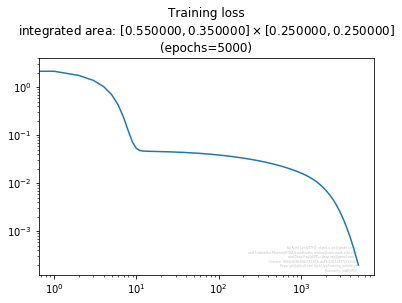

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


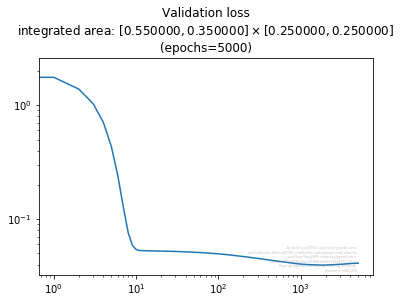

(8192,)
(8192, 1)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


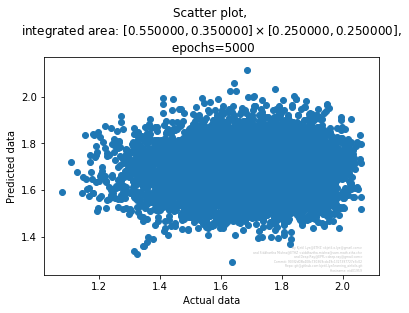

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               8200      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 220)               44220     
_________________________________________________________________
activation_2 (Activation)    (None, 220)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               44200     
_________________________________________________________________
activation_3 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 220)               44220     
__________

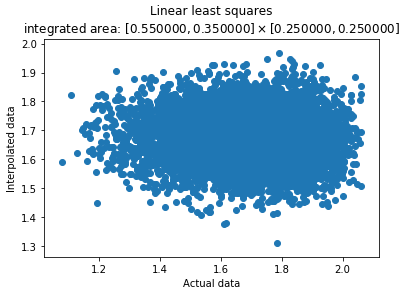

variance single level = 0.026476
variance diff ml = 0.035564 
speedup = 0.372220
(8192,)
variance_diff_interpolate = 0.033717
mean_qmc = 1.681843
mean_ml = 1.682635
mean_few_qmc = 19.843750
mean_lsq = 1.678671
(8192,)
mean_mlmlmc = 1.682713
var_qmc = 0.026476
var_ml = 0.009620
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.006758
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


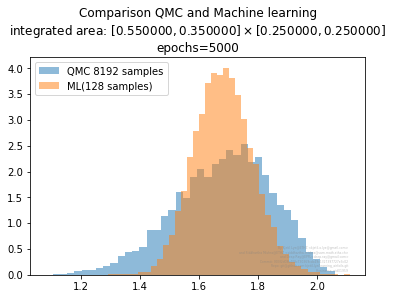

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


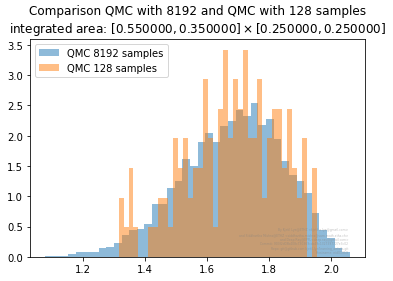

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


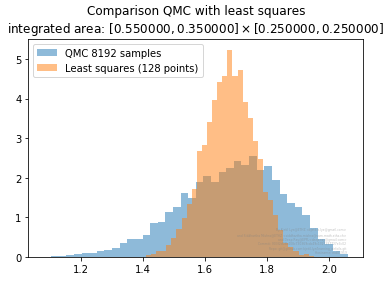

In [10]:
network, data, parameters = get_network_interpolate_qmc(data_path, AreaFunctional(), 5000)

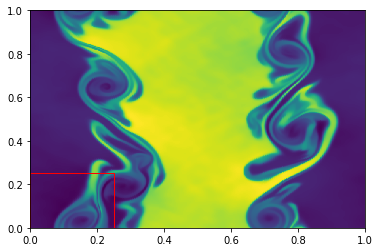

8191
Reading all samples took 136.13280582427979 seconds
<class 'numpy.ndarray'>
(8192,)


In [ ]:
variables = ['rho', 'E', 'p']

points = []

for x in [0.0,0.25,0.5,0.75]:
    for y in [0.0,0.25,0.5,0.75]:
        points.append([x,y])
epochs = [500000, 5000]

for epoch in epochs:
    for v in variables:
        for p in points:
        
            
            prefix = '%s_%f_%f' % (v, p[0], p[1])
            prefix = prefix.replace('.','_')
            showAndSave.prefix = 'kh_%d_%s' % (epoch, prefix)

            network, data, parameters = get_network_interpolate_qmc(data_path, AreaFunctional(integrate_coordinate=p,variable=v), epoch)

points = [[0.5,0.7], [0.7,0.5],[0.5,0.8],[0.8,0.5]]
for epoch in epochs:
    for v in variables:
        for p in points:
        
            prefix = '%s_%f_%f' % (v, p[0], p[1])
            prefix = prefix.replace('.','_')
            showAndSave.prefix = 'kh_single_%d_%s' % (epoch, prefix)
            network, data, parameters = get_network_interpolate_qmc(data_path, SinglePointFunctional(coordinate=p,variable=v), epoch)
            

In [ ]:
samples = get_samples(data_path, AreaFunctional())

In [ ]:
parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
parameters = loadtxt(parameter_path)
from sklearn import linear_model
data = samples

print(data)
reg_size = 128
reg = linear_model.LinearRegression()
y_train = data[:reg_size]
coeffs = reg.fit(parameters[:reg_size,:], y_train)

evaluated_lsq = coeffs.predict(parameters)
plt.scatter(data, evaluated_lsq)
plt.title('Least squares of degree 1')
plt.xlabel("Actual data")
plt.ylabel("Interpolated data")
plt.show()
print(sum(evaluated_lsq)/len(evaluated_lsq))
print(sum(data)/len(data))
print(var(data))
print(var(evaluated_lsq))

In [ ]:
func=AreaFunctional()
with netCDF4.Dataset(data_path) as f:
    d = f.variables['sample_10_rho'][:,:,0]
    r = func(d)
    print(r)

In [ ]:

a=linspace(0,10)
print(isnan(a))
print(type(samples))
print(type(a))
print(samples.shape)
print(a.shape)
print(a.dtype)
print(samples.dtype)
samples2 = samples.astype(float64)
print(samples[0])
print(isnan(samples2))


In [ ]:
import time
for x in range(100):
    %time
    time.sleep(10)